## Project Structure
```
2DIP_exercise/
│-- data/             # Contains images & videos
│   │-- input/        # 1 image and 1 video for each phase respectively
│   │-- output/       # All output images/videos must be stored here
│-- notebooks/        # Jupyter Notebooks for each phase
│   │-- part1.ipynb   # Image processing & feature extraction
│   │-- part2.ipynb   # Optical flow, object detection and tracking 
│-- README.md         # Project instructions
```

In [1]:
# imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
print(os.getcwd())  # e.g., 'C:/Users/Username/Documents'


F:\A_rptu\fourth semester\2d Image Processing\excercises\excersice_1\2dip-excercise\notebooks


In [3]:
# define paths
base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
inputs = os.path.join(base_path, 'data','input')
outputs = os.path.join(base_path, 'data','output')

## Supplementary Code for Visualization

In [4]:
def display_images(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

## Task 1 : Use image features to detect traffic signs in street images. **(7)**

a) Identify the type of noise and denoise the images. Use these denoised images for the next tasks. **(1)**

In [5]:

def denoise(input_path, output_path):
    image = cv2.imread(input_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {input_path}")
    
    # Step 1: Denoise using median filter
    denoised = cv2.medianBlur(image, 3)  # Median filter with kernel size 3
    
    # Step 2: Sharpen the image
    # Define a sharpening kernel
    sharpening_kernel = np.array([[0, -1, 0],
                                  [-1, 5, -1],
                                  [0, -1, 0]])
    
    # Apply the sharpening kernel
    sharpened = cv2.filter2D(denoised, -1, sharpening_kernel)
    
    # Save and return the final result
    cv2.imwrite(output_path, sharpened)
    return sharpened

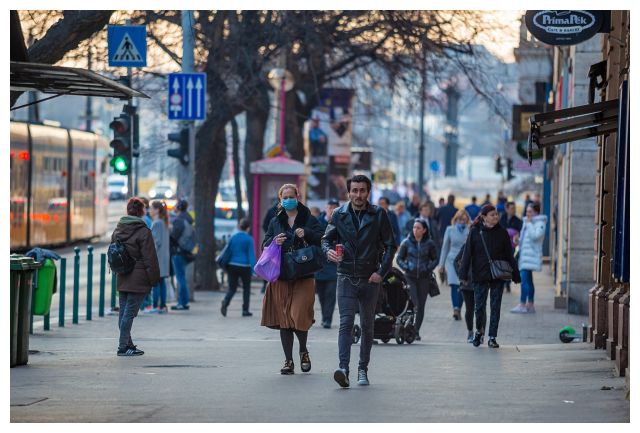

In [6]:
image_path = os.path.join(inputs, 'part1.jpg')
output_path = os.path.join(outputs, 'denoised_image.jpg')

image = denoise(image_path, output_path)
display_images(image)

b) Detect regions corresponding to traffic signs. **(3)**

In [84]:

def segment_traffic_signs(image_path, output_path):
    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at: {image_path}")

    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define narrow blue range for traffic signs
    lower_blue = np.array([100, 180, 70])
    upper_blue = np.array([130, 255, 255])
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # Morphological operations to clean mask
    kernel = np.ones((5, 5), np.uint8)
    blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_CLOSE, kernel)
    blue_mask = cv2.morphologyEx(blue_mask, cv2.MORPH_OPEN, kernel)

    # Optional: Use Canny edge detector to refine structure
    edges = cv2.Canny(blue_mask, 100, 200)
    
    # Find contours on the mask
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    result = image.copy()
    count = 0
    for cnt in contours:
      area = cv2.contourArea(cnt)
      if 10000 < area < 17000:
         approx = cv2.approxPolyDP(cnt, 0.04 * cv2.arcLength(cnt, True), True)
         
         if 4 <= len(approx) <= 10:
             x, y, w, h = cv2.boundingRect(cnt)
             aspect_ratio = w / float(h)
             if 0.6 < aspect_ratio < 1.1:
                print(f"[DETECTED] Area: {area:.1f}, Vertices: {len(approx)}, AR: {aspect_ratio:.2f}")
                cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 4)
                count += 1

    print(f"[INFO] Detected {count} possible traffic sign(s).")

    # Save and return result
    cv2.imwrite(output_path, result)
    return result

[DETECTED] Area: 14385.5, Vertices: 9, AR: 0.77
[DETECTED] Area: 15865.0, Vertices: 4, AR: 0.95
[INFO] Detected 2 possible traffic sign(s).


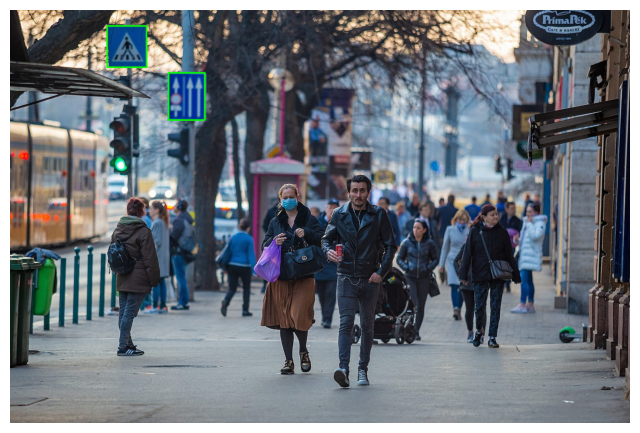

In [85]:
image_path = os.path.join(outputs, 'denoised_image.jpg')
output_path = os.path.join(outputs, 'color_segmented_image.jpg')

image = segment_traffic_signs(image_path, output_path)
display_images(image)

c) Refine detected region boundaries with appropriate methods. **(3)**

In [91]:
def refine_traffic_signs(image_path, output_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at: {image_path}")

    # Convert to grayscale and threshold to get binary mask
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

    # Morphological operations to smooth the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Find contours on mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    result = image.copy()

    print("[DEBUG] Contours found and their properties:")
    for i, cnt in enumerate(contours):
        area = cv2.contourArea(cnt)
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        solidity = area / hull_area if hull_area != 0 else 0
        epsilon = 0.02 * cv2.arcLength(hull, True)
        approx = cv2.approxPolyDP(hull, epsilon, True)
        x, y, w, h = cv2.boundingRect(approx)
        aspect_ratio = w / float(h)

        #print(f"Contour {i}: area={area:.1f}, hull_area={hull_area:.1f}, solidity={solidity:.2f}, "
              #f"vertices={len(approx)}, aspect_ratio={aspect_ratio:.2f}")

        # Filtering conditions - tune these based on your signs
        if 12000 < area < 16000 and 0.85 < solidity <= 1.0 and 0.7 < aspect_ratio < 1.1:
            # Draw refined contour and bounding box
            cv2.drawContours(result, [approx], -1, (0, 0, 255), 3)  # Red contour
            cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green bounding box

    cv2.imwrite(output_path, result)
    print("[INFO] Refinement complete and image saved.")
    return result
    
    

[DEBUG] Contours found and their properties:
[INFO] Refinement complete and image saved.


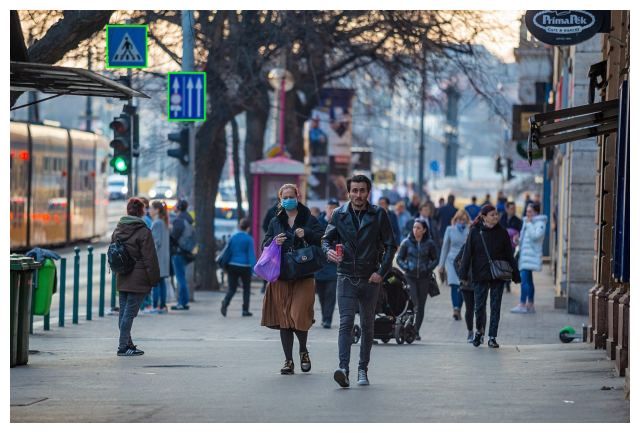

In [92]:
image_path = os.path.join(outputs, 'color_segmented_image.jpg')
output_path = os.path.join(outputs, 'refined_traffic_signs.jpg')

image = refine_traffic_signs(image_path, output_path)
display_images(image)

## Task 2 : Feature extraction and detection of pedestrians. **(8)**

a) Use an appropriate alogorithm to detect pedestrians. Draw bounding boxes around the detected pedestrians. **(3)**

In [95]:
def non_max_suppression_fast(boxes, overlapThresh):
    if len(boxes) == 0:
        return []

    boxes = np.array(boxes)
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    pick = []

    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = idxs[-1]
        pick.append(last)

        xx1 = np.maximum(x1[last], x1[idxs[:-1]])
        yy1 = np.maximum(y1[last], y1[idxs[:-1]])
        xx2 = np.minimum(x2[last], x2[idxs[:-1]])
        yy2 = np.minimum(y2[last], y2[idxs[:-1]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        overlap = (w * h) / area[idxs[:-1]]
        idxs = np.delete(idxs, np.concatenate(([len(idxs) - 1], np.where(overlap > overlapThresh)[0])))

    return boxes[pick].astype("int")

In [156]:
def detect_pedestrians(image_path, output_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at: {image_path}")

    hog = cv2.HOGDescriptor()
    hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

    image_resized = cv2.resize(image, (0, 0), fx=1.0, fy=1.0)

    (rects, weights) = hog.detectMultiScale(image_resized,
                                            winStride=(4, 4),
                                            padding=(8, 8),
                                            scale=1.04)

    threshold = 0.8
    shrink_factor = 0.04  # Shrinks box size by 4%

    strong_rects = []
    for i, (x, y, w, h) in enumerate(rects):
       aspect_ratio = h / float(w)
       if weights[i] > threshold and 1.8 < aspect_ratio < 3.5 and h > 250:
            dx = int(w * shrink_factor / 2)
            dy = int(h * shrink_factor / 2)
            x1 = x + dx
            y1 = y + dy
            x2 = x + w - dx
            y2 = y + h - dy
            strong_rects.append([x1, y1, x2, y2])

    final_boxes = non_max_suppression_fast(strong_rects, overlapThresh=0.65)

    for (xA, yA, xB, yB) in final_boxes:
        cv2.rectangle(image_resized, (xA, yA), (xB, yB), (0, 255, 0), 3)

    cv2.imwrite(output_path, image_resized)
    return image_resized


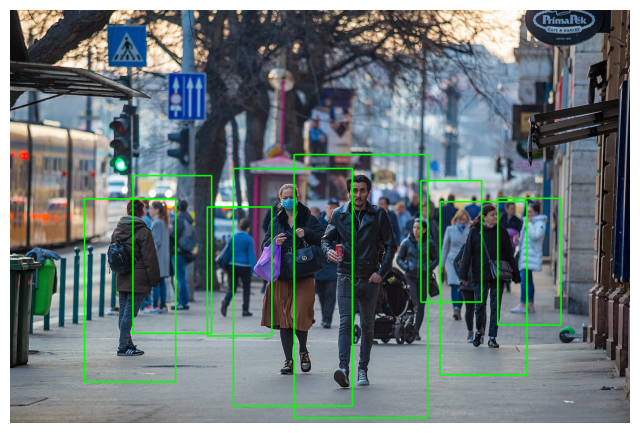

In [157]:
input_path = os.path.join(outputs, 'denoised_image.jpg')
output_path = os.path.join(outputs, 'pedestrians.jpg')

image = detect_pedestrians(input_path, output_path)
display_images(image)

b) Detect faces of pedestrian and draw a bounding box around detected faces. **(3)**

In [182]:
def detect_faces(input_path, output_path):
    image = cv2.imread(input_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # HOG person detector
    hog = cv2.HOGDescriptor()
    hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
    rects, _ = hog.detectMultiScale(gray, winStride=(8, 8), padding=(8, 8), scale=1.05)

    # Haar face detector
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    for (x, y, w, h) in rects:
        # Skip if box is too small or has unusual shape
        if h < 250 or w < 30 or h / w < 1.2:
            continue

        # Face region = upper 60% of the person box
        top = y
        bottom = y + int(0.6 * h)
        face_region_gray = gray[top:bottom, x:x + w]
        face_region_color = image[top:bottom, x:x + w]

        # Detect faces with stricter settings
        faces = face_cascade.detectMultiScale(
            face_region_gray,
            scaleFactor=1.1,
            minNeighbors=7,
            minSize=(30, 30)
        )

        for (fx, fy, fw, fh) in faces:
            # Filter face candidates by reasonable aspect ratio
            aspect_ratio = fw / float(fh)
            if 0.7 < aspect_ratio < 1.3:
                cv2.rectangle(image, (x + fx, top + fy), (x + fx + fw, top + fy + fh), (255, 0, 0), 2)

    # Save output
    cv2.imwrite(output_path, image)
    return image


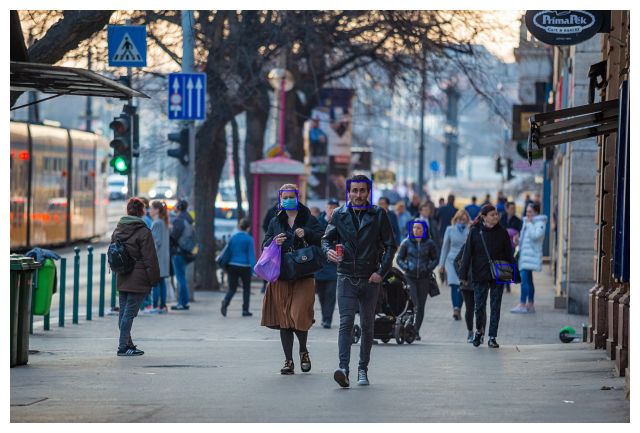

In [183]:
input_path = os.path.join(outputs, 'denoised_image.jpg')
output_path = os.path.join(outputs, 'faces.jpg')

image = detect_faces(input_path, output_path)
display_images(image)

c) Briefly discuss the methods used for the above tasks. **(2)**

In [ ]:
#TODO c):